NAIROBI OZONESONDE DATA AVAILABILITY

Total launches from 1998 to 2024: 1044


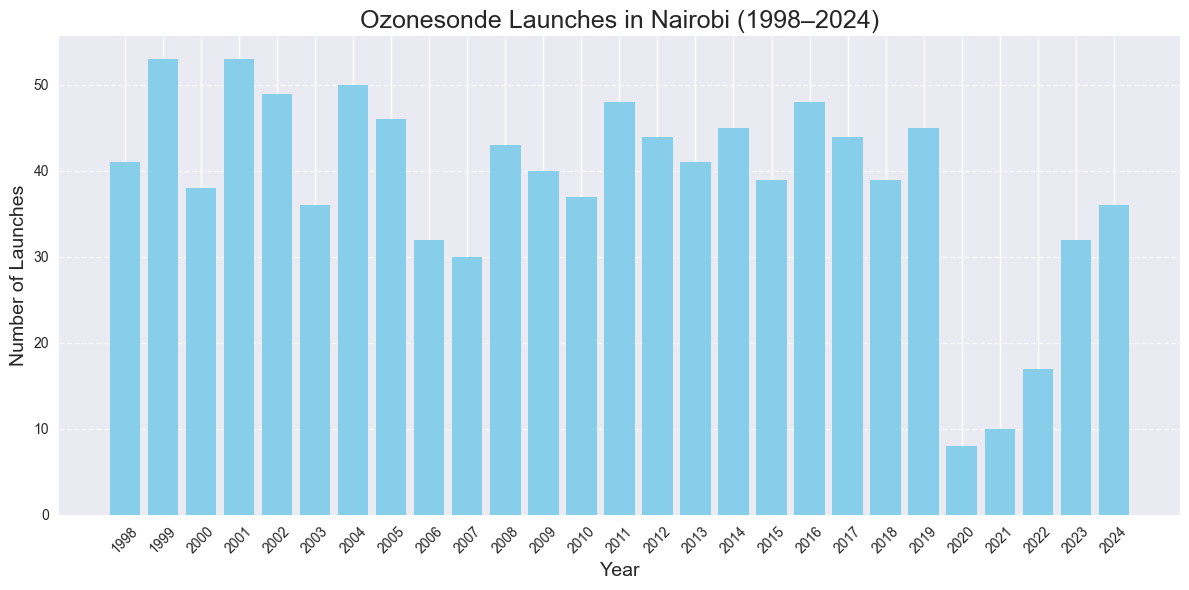

In [21]:
import os
import matplotlib.pyplot as plt

# data Configuration
base_dir = "Ozonesondes"
start_year, end_year = 1998, 2024

years = sorted({
    int(tok)
    for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d))
    for tok in d.split("_")
    if tok.isdigit() and start_year <= int(tok) <= end_year
})

# Count launches per year
launch_counts = []
for year in years:
    year_folder = f"shadoz_nairobi_{year}_V06"
    path = os.path.join(base_dir, year_folder)
    try:
        files = [f for f in os.listdir(path)
                 if os.path.isfile(os.path.join(path, f))]
        count = len(files)
    except FileNotFoundError:
        count = 0
    launch_counts.append(count)

# Total count calculation
total_launches = sum(launch_counts)
print(f"Total launches from {start_year} to {end_year}: {total_launches}")

# Plotting 
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(years, launch_counts, color="skyblue")
ax.set_title("Ozonesonde Launches in Nairobi (1998–2024)", fontsize=18)
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Number of Launches", fontsize=14)

ax.set_xticks(years)
ax.set_xticklabels(years, rotation=45, fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


OZONE VERTICAL PROFILE FOR 30TH OCT 2024

      GeopAlt   Temp  O3_mPa
0       1.790  25.00  3.4211
1       1.803  23.67  3.4606
2       1.806  23.58  3.4606
3       1.810  23.42  3.4607
4       1.813  23.30  3.4607
...       ...    ...     ...
7076   33.193 -37.98  6.7099
7077   33.193 -37.93  6.7099
7078   33.202 -37.87  6.6709
7079   33.202 -37.80  6.6312
7080   33.212 -37.71  6.6318

[7081 rows x 3 columns]
Extracted 7081 rows and 3 columns


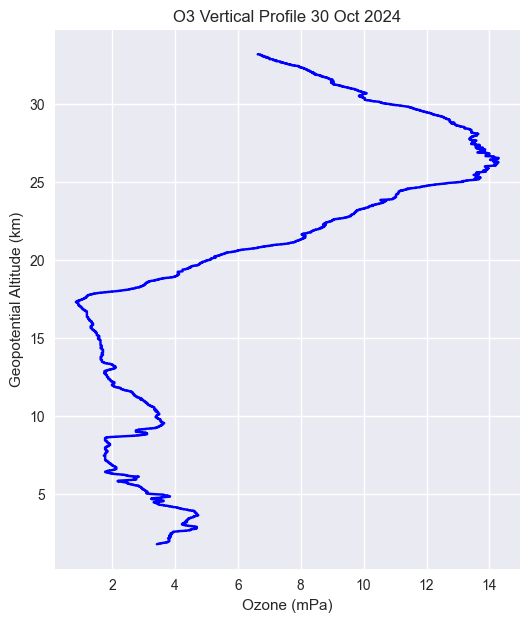

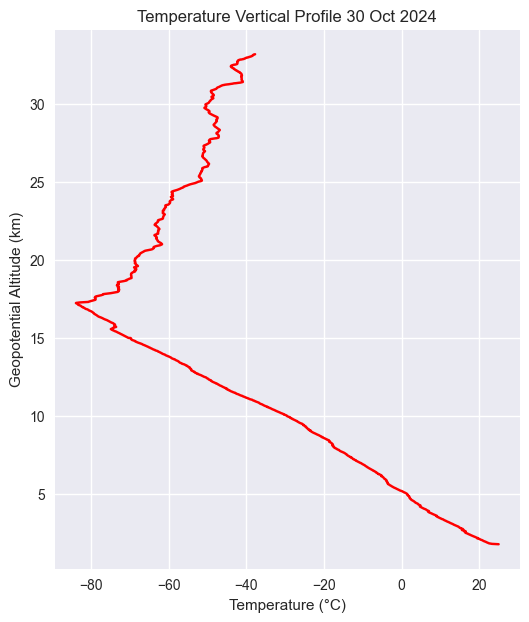

In [22]:
import os
import glob
import pandas as pd

# pick a specific launch
base_dir    = "Ozonesondes"
year_folder = os.path.join(base_dir, "shadoz_nairobi_2024_V06")
pattern     = os.path.join(year_folder, "nairobi_20241030T07_SHADOZV06*")
launch_file = glob.glob(pattern)[0]

# find the header row
header_line_idx = None
with open(launch_file, 'r') as f:
    for idx, line in enumerate(f):
        if line.lstrip().startswith("Time") and "GeopAlt" in line and "O3_mPa" in line:
            header_line_idx = idx
            break
if header_line_idx is None:
    raise ValueError("Could not find header line containing 'Time' and 'GeopAlt'")

# skip everything before the header
skiprows    = list(range(header_line_idx)) + [header_line_idx + 1]

# read all data, selecting only the three target columns ["GeopAlt", "O3_mPa", "Temp"]
ozone = pd.read_csv(
    launch_file,
    sep=r'\s+',
    engine='python',
    skiprows=skiprows,
    header=0,
    usecols=["GeopAlt", "O3_mPa", "Temp"]
)

# inspect full DataFrame
print(ozone)

# confirm you have all rows
print(f"Extracted {ozone.shape[0]} rows and {ozone.shape[1]} columns")

# plotting

import matplotlib.pyplot as plt

# Ozone profile figure
fig_o3, ax_o3 = plt.subplots(figsize=(6, 7))
ax_o3.plot(ozone['O3_mPa'], ozone['GeopAlt'], color='blue')
ax_o3.set_xlabel('Ozone (mPa)')
ax_o3.set_ylabel('Geopotential Altitude (km)')
ax_o3.set_title('O3 Vertical Profile 30 Oct 2024')
ax_o3.grid(True)

# Temperature profile figure
fig_temp, ax_temp = plt.subplots(figsize=(6, 7))
ax_temp.plot(ozone['Temp'], ozone['GeopAlt'], color='red')
ax_temp.set_xlabel('Temperature (°C)')
ax_temp.set_ylabel('Geopotential Altitude (km)')
ax_temp.set_title('Temperature Vertical Profile 30 Oct 2024')
ax_temp.grid(True)



plt.show()
